In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns
import time

In [2]:
SEED = 0
NUM_ANTS = int(1e2)
MAX_STEPS = 100

In [3]:
np.random.seed(SEED)

In [241]:
def square(x, y):
    if -2<x<2 and -2<y<2:
        return True
    return False

def constraints(x, y):
    if x+y<1:
        return True
    return False

In [242]:
constraints = square

In [243]:
class Ants():
    def __init__(self, n:int) -> None:
        if n<=0:
            raise ValueError("Error: 'n' must be a positive integer")
        self.num_initial = n
        self.num_alive = n
        self.perc_alive = 1.0
        self.step = 0
        self.death_history = {0: 0}
        self.positions = self.initial_positions()
        self.possible_moves =  np.array([[1,0], [-1,0], [0,1], [0,-1]])
        self.position_summary = {}

    def initial_positions(self):
        
        positions = pd.DataFrame(columns = ['x', 'y'])
        positions['x'] = np.zeros(self.num_initial)
        positions['y'] = np.zeros(self.num_initial)
        
        return positions

    def move(self):
        self.step +=1
        # create random moves per each ant
        moves = self.possible_moves[np.random.choice(4, self.num_alive)]
        # make move
        self.positions += moves
        # check if the ant reaches the food
        alive = self.positions.apply(lambda pos: constraints(pos['x'], pos['y']), axis=1)
        self.death_history[self.step] = (~alive).astype(int).sum()
        self.num_alive -= self.death_history[self.step]
        self.perc_alive = self.num_alive/self.num_initial
        self.positions = self.positions[alive]
        return self.death_history[self.step]
    
    def summarize_positions(self):
        summary = self.positions.value_counts()
        self.position_summary[self.step]= summary
        return summary



In [244]:
class Grid():
    def __init__(self, height:int, width:int, default_value=np.nan, constraints=None) -> None:
        
        assert height>0
        assert width>0
        self.height = height
        self.width = width
        self.index = np.flip(np.arange(self.height)) - self.height//2
        self.columns = np.arange(self.width) - self.width//2
        self.default_value = default_value
        
        self.default_grid = None
        self.initialize_grid()
        self.grid = self.default_grid
        #self.update_grid(changes)
        self.mask = None
        self.mask = self.initialize_mask(constraints)


    def initialize_grid(self):
        grid = np.full([self.height, self.width], self.default_value)
        grid = pd.DataFrame(data=grid, index=self.index, columns=self.columns)
        self.default_grid = grid
        return grid

    def update_grid(self, changes, from_default=True):
        #if changes!=None:
        # if from_default=True it starts the changes form the default grid, otherise fromt the actual one
        if from_default:
            self.grid = self.default_grid.copy()
        # update the grid
        if changes.size>=1:
            
            for x,y in changes.index:
                # the grid could be smaller than the indeces in 'changes'
                if x in set(self.columns) and y in set(self.index):
                    self.grid.at[y,x] = changes[x,y]

        return self.grid

    def initialize_mask(self, constraints):
        if constraints!=None:
            # create every possible combination between 2 arrays
            mask = pd.DataFrame(index = pd.MultiIndex.from_product([self.index, self.columns]))
            mask.index.set_names(['y', 'x'], inplace=True)
            # evaluate the constraint function in each point
            mask['mask'] = mask.reset_index().apply(lambda pos: not constraints(pos['x'], pos['y']), axis=1).values
            # tranform from 1D to 2D
            mask = mask.unstack(level=1) # level=1 means that the indeces would be the y
            # drop the name "mask" from the columns
            mask = mask.droplevel(level=0, axis=1)
            # unstack changes th order of the indexes, so we have to sorte them again
            mask = mask.sort_index(ascending=False, axis=0)
            mask = mask.sort_index(ascending=True, axis=1)
            # update the mask
            self.mask = mask
            return mask
        return None
    
    def plot(self, vmax=None, masked:bool=False):
        
        # add mask
        if masked:
            sns.heatmap(
                data = self.mask, 
                vmin = 0, 
                vmax = 10, 
                cmap = 'Blues', 
                annot = False,
                linewidths = 0.5,
                cbar = False
                )
        ax = sns.heatmap(
            data = self.grid, 
            vmin = 0, 
            vmax = vmax, 
            cmap = 'rocket_r', 
            annot = True,
            linecolor='white',
            linewidths = 0.5, 
            xticklabels=True, 
            yticklabels=True
            )
        plt.show()
        return ax
        

In [246]:
def tracking(num_ants, max_steps=1, grid_height=10, grid_width=10, wait_time:int=None):
    
    ants = Ants(num_ants)
    grid = Grid(grid_height, grid_width)
    start_change = pd.Series(data = [num_ants], index=[(0,0)])
    grid.update_grid(changes=start_change)
    grid.initialize_mask(constraints=constraints)

    starttime = time.time()


    while ants.step<=max_steps and ants.num_alive>0:
        clear_output(wait=True)
        ants.move()
        grid.update_grid(changes=ants.summarize_positions())
        grid.plot(vmax=num_ants, masked=True)
        #if ants.step%1==0 or ants.step>max_steps or ants.num_alive<=0:
        print(f'step\talive\talive%\tdeath_now')
        print(f'{ants.step}\t{ants.num_alive}\t{ants.perc_alive}\t{ants.death_history[ants.step]}')

        if wait_time:
            time.sleep(wait_time - ((time.time() - starttime) % wait_time))

    death_history = pd.DataFrame.from_dict(ants.death_history, orient='index', columns=['num'])
    death_history.index.name = 'step'
    death_history.sort_index(inplace=True)


    return death_history, ants, grid

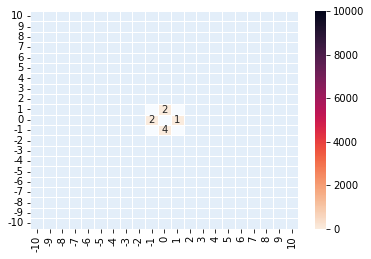

step	alive	alive%	death_now
21	9	0.0009	3


In [247]:
# print('Ants creation...')
# ants = Ants(NUM_ANTS)
print('Movements tracking...')
death_history, ants, grid = tracking(num_ants=10000, max_steps=20, grid_height=21, grid_width=21, wait_time=1)

<AxesSubplot:xlabel='step'>

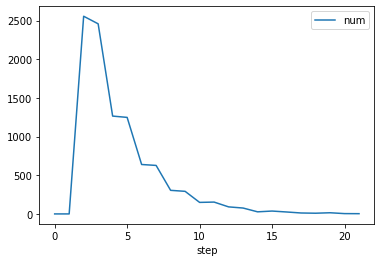

In [248]:
death_history.plot()